#Task 1 : ** Creating and Training AutoEncoder Model thats I/O 254x254 on given set of images **

Downloading the data from the link

In [1]:
!gdown https://drive.google.com/u/0/uc?id=10J97YhL_0YB298fqekLm0t9rU9jRWEoD -O quixel_training_data.zip

Downloading...
From: https://drive.google.com/u/0/uc?id=10J97YhL_0YB298fqekLm0t9rU9jRWEoD
To: /content/quixel_training_data.zip
100% 1.16G/1.16G [00:04<00:00, 263MB/s]


Unzip the data using Linux Command.

In [2]:
!unzip quixel_training_data.zip

Archive:  quixel_training_data.zip
   creating: train-data/
   creating: train-data/okyjD0/
  inflating: train-data/okyjD0/okyjD_2K_Albedo.jpg  
  inflating: train-data/okyjD0/semanticTags.json  
   creating: train-data/okyjF0/
  inflating: train-data/okyjF0/okyjF_2K_Albedo.jpg  
  inflating: train-data/okyjF0/semanticTags.json  
   creating: train-data/okyjJ0/
  inflating: train-data/okyjJ0/okyjJ_2K_Albedo.jpg  
  inflating: train-data/okyjJ0/semanticTags.json  
   creating: train-data/okyjl0/
  inflating: train-data/okyjl0/okyjl_2K_Albedo.jpg  
  inflating: train-data/okyjl0/semanticTags.json  
   creating: train-data/okyjp0/
  inflating: train-data/okyjp0/okyjp_2K_Albedo.jpg  
  inflating: train-data/okyjp0/semanticTags.json  
   creating: train-data/okyjpmp0/
  inflating: train-data/okyjpmp0/okyjpmp_2K_Albedo.jpg  
  inflating: train-data/okyjpmp0/semanticTags.json  
   creating: train-data/okyjqtp0/
  inflating: train-data/okyjqtp0/okyjqtp_2K_Albedo.jpg  
  inflating: train-data/o

Importing different Python Libraries and Packages 
1. cv2 For Random Croping Images i.e. Image Processing Operations
2. json For Reading JSON files along Images
3. shutil For Copy Operations
4. os Operating System Operations
5. numpy for numerical operations 
6. torch: PyTorch Neural Network Package
7. torchvision: For Computer Vision Operations
8. matplotlib: ploting different Curves


In [3]:
import cv2
import json
import shutil
import glob
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.utils.data as data
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.nn import functional as F
from IPython.display import set_matplotlib_formats
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

Reading path of Images and JSON files

In [4]:
image_files=glob.glob('train-data/**/*.jpg')
json_files=glob.glob('train-data/**/*.json')

###Assumption: We are creating 2 Class. 0 For Images Containing Grass and 1 For Images not containing Grass

Creating Training and Validation Folder with Class Folders i.e. 0 and 1

In [5]:
!mkdir training_images
!mkdir training_images/0
!mkdir training_images/1

In [6]:
!mkdir validation_images
!mkdir validation_images/0
!mkdir validation_images/1

Croping an Image Randomly with specific size

In [7]:
def get_random_crop(image, crop_height, crop_width):
    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop


Saving the crop image using OpenCV

In [8]:
def crop_and_save_img(file_name,crop_height,crop_width,save_path):
  image_file_name=os.path.basename(file_name)
  img=cv2.imread(file_name)
  for i in range(6):
    random_crop_img=get_random_crop(img, crop_height, crop_width)
    cv2.imwrite(save_path+image_file_name[:-4]+'_{}.jpg'.format(i),random_crop_img)

Defining specific Height and Width i.e. 254x254

In [9]:
crop_height=254
crop_width=254

Iterate over all image_files and organizing them in respective folders of classes based on assumption stated above. 

** Assumption 2: ** Keeping every 5th image for validation purpose

In [10]:
i=0
for (counter,file_name) in enumerate(image_files):
    image_file_name=os.path.basename(file_name)
    json_file_data=open(json_files[counter])
    json_data=json.load(json_file_data)
    if 'Grass' in json_data['contains'] or 'grass' in json_data['contains']:
      if i%5!=0:
        crop_and_save_img(file_name,crop_height,crop_width,'training_images/0/')
      else:
        crop_and_save_img(file_name,crop_height,crop_width,'validation_images/0/')
    else:
      if i%5!=0:
        crop_and_save_img(file_name,crop_height,crop_width,'training_images/1/')
      else:
        crop_and_save_img(file_name,crop_height,crop_width,'validation_images/1/')
    i=i+1

Reading the names/paths of training and validation images

In [11]:
training_images=glob.glob('training_images/**/*.jpg')

In [12]:
validation_images=glob.glob('validation_images/**/*.jpg')

In [13]:
print('Total Training Samples {} Total Validation Samples {}'.format(len(training_images),len(validation_images)))

Total Training Samples 1440 Total Validation Samples 360


Checking if GPU/Cuda is available or not

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cuda')

Defining the pytorch transform for changing Numpy array image to tensor.

In [16]:
transform = transforms.Compose([transforms.Resize((254, 254)),transforms.ToTensor()])

Defining Tarining and Validation Pytroch Dataset based image directories. Also Defining ***dataloaders*** with **Batch Size of 16**

In [17]:
train_dataset = datasets.ImageFolder('/content/training_images', transform=transform)

In [18]:
valid_dataset = datasets.ImageFolder('/content/validation_images', transform=transform)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [20]:
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)

Defining the Neural Network Architecture . A Pytorch based **Autoencoder Model**

*detail of model is given in comments below*

In [21]:

# define the NN architecture
class ConvAutoencoder1(nn.Module):
    def __init__(self):
        super(ConvAutoencoder1, self).__init__()
        ### Encoder Block ===> Convolutional Layers are Downsampling here.
        ## First Convolutional Block Get a 3-Channel Image and Return the image with depth 256
        # Getting a 3-Channel Images and Adding Padding 2 to make it 256x256 Size.
        # Layer conv_11 Have Padding of 2. Other all Layers in Encoder have padding of 1 and Kernal Size 3x3
        self.conv_11= nn.Conv2d(3,256,3,padding=2)
        self.conv_12= nn.Conv2d(256,256,3,padding=1)
        #Applying Pooling Operation with Stride of 2 to Reduce Image by Half
        self.pool=nn.MaxPool2d(2,2)
        ## 2nd Convolutional Block Get a 256 Depth Image and Return the image with depth 128
        self.conv_21= nn.Conv2d(256,256,3,padding=1)
        self.conv_22= nn.Conv2d(256,128,3,padding=1)
        ## 3rd Convolutional Block Get a 128 Depth Image and Return the image with depth 64
        self.conv_31= nn.Conv2d(128,128,3,padding=1)
        self.conv_32= nn.Conv2d(128,128,3,padding=1)
        self.conv_33= nn.Conv2d(128,64,3,padding=1)
        ## 4th Convolutional Block Get a 64 Depth Image and Return the image with depth 32
        self.conv_41= nn.Conv2d(64,64,3,padding=1)
        self.conv_42= nn.Conv2d(64,64,3,padding=1)
        self.conv_43= nn.Conv2d(64,64,3,padding=1)
        self.conv_44= nn.Conv2d(64,32,3,padding=1)
        ## 5th Convolutional Block Get a 32 Depth Image and Return the image with depth 8
        self.conv_51= nn.Conv2d(32,32,3,padding=1)
        self.conv_52= nn.Conv2d(32,16,3,padding=1)
        self.conv_53= nn.Conv2d(16,8,3,padding=1)
        ## FC Layer Getting the Flatten Output of conv_53 
        self.e_fc= nn.Linear(8*8*8, 512)


        ### Decoder Block ====>  ConvTranspose2d or Deconvolutional Layer will do work of Upsampling

        self.d_fc= nn.Linear(512,8*8*8)

        #1st Transpose Convolutional Block for 5th Convolutional Block of Encoder
        #Every Layer will have paddding and stride of 1 but 1st layer of every Transpose Convolutional Block have stride of 2 and Kernal of 4 to double the image size
        ## It get a 8x8 image and return 16x16
        self.tconv_53= nn.ConvTranspose2d(8, 16, 4, stride=2, padding=1)
        self.tconv_52= nn.ConvTranspose2d(16, 32, 3, stride=1, padding=1)
        self.tconv_51= nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1)
        #2nd Transpose Convolutional Block for 4th Convolutional Block of Encoder
        ## It get a 16x16 image and return 32x32
        self.tconv_44= nn.ConvTranspose2d(32, 64, 4, stride=2, padding=1)
        self.tconv_43= nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1)
        self.tconv_42= nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1)
        self.tconv_41= nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1)
        #3rd Transpose Convolutional Block for 3th Convolutional Block of Encoder
        ## It get a 32x32 image and return 64x64
        self.tconv_33= nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1)
        self.tconv_32= nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1)
        self.tconv_31= nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1)
        #4th Transpose Convolutional Block for 2nd Convolutional Block of Encoder
        ## It get a 64x64 image and return 128x128
        self.tconv_22= nn.ConvTranspose2d(128, 256, 4, stride=2, padding=1)
        self.tconv_21= nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1)
        #5th Transpose Convolutional Block for 1st Convolutional Block of Encoder
        ## It get a 128x128 image and return 254x254
        self.tconv_12= nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.tconv_11= nn.ConvTranspose2d(256,  3, 3, stride=1, padding=2)

        
    def forward(self, x):
        #Every Convolutional Layer have activation function Relu
        #DownSampling 
        x = F.relu(self.conv_11(x))
        x = F.relu(self.conv_12(x))
        x = self.pool(x)
        x = F.relu(self.conv_21(x))
        x = F.relu(self.conv_22(x))
        x = self.pool(x)
        x = F.relu(self.conv_31(x))
        x = F.relu(self.conv_32(x))
        x = F.relu(self.conv_33(x))
        x = self.pool(x)
        x = F.relu(self.conv_41(x))
        x = F.relu(self.conv_42(x))
        x = F.relu(self.conv_43(x))
        x = F.relu(self.conv_44(x))
        x = self.pool(x)
        x = F.relu(self.conv_51(x))
        x = F.relu(self.conv_52(x))
        x = F.relu(self.conv_53(x))
        x = self.pool(x)
        #Flattening the Output of Encoder 
        x = torch.flatten(x, 1)
        z = F.relu(self.e_fc(x)) #512 Feature Vectore

        #Constructing the 8x8 image from feature Vectore
        x = F.relu(self.d_fc(z))
        x = x.reshape(x.shape[0], -1, 8, 8)

        #Upsampling by Decoder Operations
        x = F.relu(self.tconv_53(x))
        x = F.relu(self.tconv_52(x))
        x = F.relu(self.tconv_51(x))

        x = F.relu(self.tconv_44(x))
        x = F.relu(self.tconv_43(x))
        x = F.relu(self.tconv_42(x))
        x = F.relu(self.tconv_41(x))

        x = F.relu(self.tconv_33(x))
        x = F.relu(self.tconv_32(x))
        x = F.relu(self.tconv_31(x))

        x = F.relu(self.tconv_22(x))
        x = F.relu(self.tconv_21(x))

        x = F.relu(self.tconv_12(x))
        x = F.sigmoid(self.tconv_11(x)) #Last layer of Decoder having Sigmoid as Activation function

        return x,z



In [22]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

In [23]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Initializing and Declaring the Model and Moving Model to GPU if available

In [24]:
model = ConvAutoencoder1()

In [25]:
model=model.to(device)

Training and Validation Function. i.e. FIT function.



*   Loss: MSE
*   LR: 0.001
*   Epochs: 10
*   Optimizer: Adam



In [27]:
def train_and_validate(epochs):
  # Loss function
  criterion = nn.MSELoss()

  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_losses=[]
  valid_losses=[]
  for e in range(1, epochs+1):
      train_loss = 0.0  # monitor training loss
      
      ###################
      # train the model #
      ###################
      for data in train_dataloader:
          images, _ = data                        # we are just intrested in just images
          images, _ = images.to(device), _.to(device)
          # no need to flatten images
          optimizer.zero_grad()                   # clear the gradients
          outputs,_ = model(images)                 # forward pass: compute predicted outputs 
          loss = criterion(outputs, images)       # calculate the loss
          loss.backward()                         # backward pass
          optimizer.step()                        # perform optimization step
          train_loss += loss.item()*images.size(0)# update running training loss
          del _   
      # print avg training statistics 
      train_loss = train_loss/len(train_dataloader)
      train_losses.append(train_loss)
      #Validation Over Validation Data
      valid_loss=0.0
      for data in valid_dataloader:
          images,_ =data
          images, _ = images.to(device), _.to(device)
          outputs,_ = model(images)
          del _
          loss = criterion(outputs, images)
          valid_loss += loss.item()*images.size(0)
      valid_loss=valid_loss/len(valid_dataloader)
      valid_losses.append(valid_loss)
      print('Epoch: {}'.format(e),
            '\tTraining Loss: {:.4f}'.format(train_loss)
            ,'\tValid Loss: {:.4f}'.format(valid_loss))
  return model, train_losses,valid_losses
      

Fitting the model over training and validation dataset.

In [28]:
model1,train_losses,valid_losses=train_and_validate(epochs=8) #Training the model for 8 Epochs 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.4813 	Valid Loss: 0.4085
Epoch: 2 	Training Loss: 0.3648 	Valid Loss: 0.4078
Epoch: 3 	Training Loss: 0.3644 	Valid Loss: 0.4099
Epoch: 4 	Training Loss: 0.3619 	Valid Loss: 0.4054
Epoch: 5 	Training Loss: 0.3616 	Valid Loss: 0.4050
Epoch: 6 	Training Loss: 0.3601 	Valid Loss: 0.4052
Epoch: 7 	Training Loss: 0.3611 	Valid Loss: 0.4055
Epoch: 8 	Training Loss: 0.3615 	Valid Loss: 0.4050


Saving Model for Future Inference Operation

In [29]:
torch.save(model1, 'model1_AE_Quixel.pth')


In [34]:
# !cp model1_AE_Quixel.pth /content/drive/MyDrive/Quixel_AE/model1_AE_Quixel.pth

Plotting Model Curves.

In [35]:
def plot_losses(train_losses,valid_losses,color1,color2,title,x_lbl,y_lbl):
  plt.plot(train_losses,color1, label='train loss')
  plt.plot(valid_losses,color2, label='valid loss')
  plt.xlabel(x_lbl)
  plt.ylabel(y_lbl)
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

Model is only training for 8 epochs. Hence it is not properly converging yet. Dataset is not also big chances of overfitting.... 

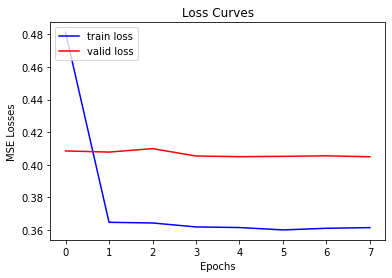

In [36]:
plot_losses(train_losses,valid_losses,color1='-b',color2='-r',title='Loss Curves',x_lbl='Epochs',y_lbl='MSE Losses')

#Task 2: Plot Cosine Similarities between Crops taken from Same images and Different Images

Creating different auxaliriy directories 

In [72]:
!rm -rf similarity_image/

In [73]:
!mkdir similarity_image
!mkdir similarity_image/task_21


In [74]:
random_images_indexes=np.random.randint(300, size=15)

Creating differnt Crops for testing cosine similarities 

In [76]:
for i in random_images_indexes:
  try:
    directory_path='similarity_image/task_21/'+os.path.basename(image_files[i])[:-4]
    os.mkdir(directory_path)
    crop_and_save_img(image_files[i],254,254,directory_path+'/')
  except Exception as e:
    print(e)
  

In [140]:
images_task21=glob.glob('/content/similarity_image/task_21/**/*.jpg')

In [160]:
def image_to_feature_numpy(image_path):
  transform = transforms.ToTensor()
  image_1=Image.open(image_path)
  image_1=transform(image_1).unsqueeze(0)
  _,z1=model1(image_1)
  z1=z1.detach().numpy()
  z1=np.squeeze(z1)
  return z1

Using Cosine similarity formula:
cosine=z1.z2/|z1||z2|


In [161]:
def cosine_simalarity(z1,z2):
  cosine = np.dot(z1,z2)/(norm(z1)*norm(z2))
  return cosine

Cosine Similarity Matrix is calculating by Randomly selecting an Image Crop and All other crops of that Image. Each Grid Title is Image Name and Cosine Similarity is displayed Over the image in **White Color**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


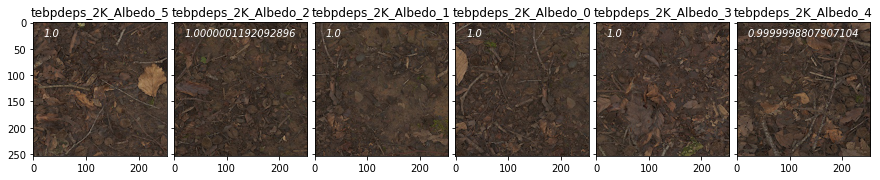

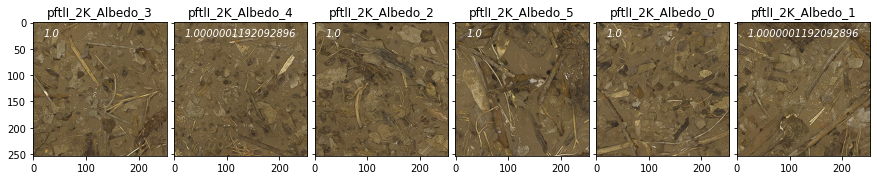

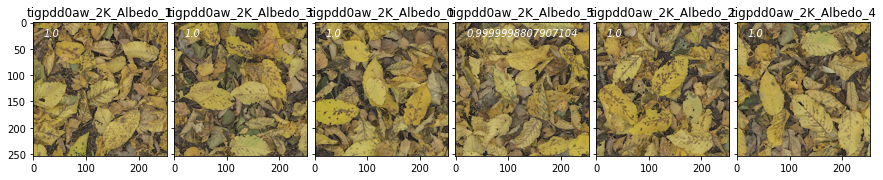

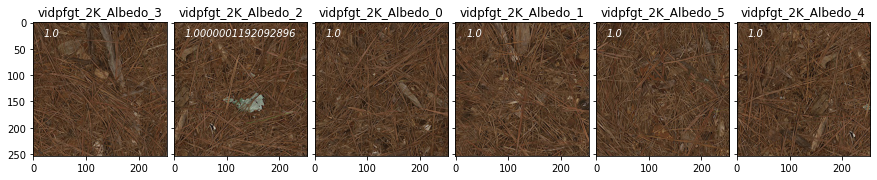

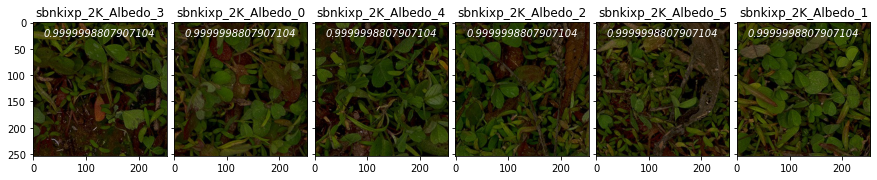

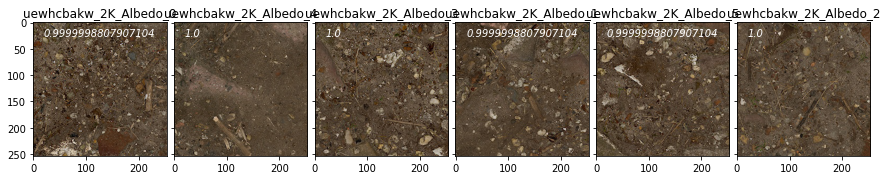

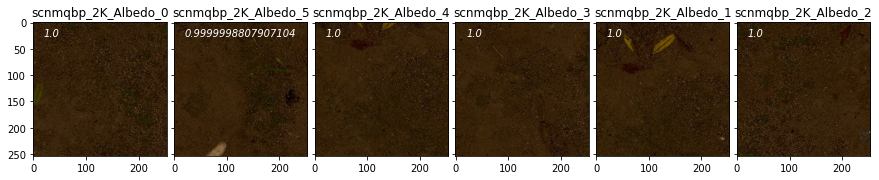

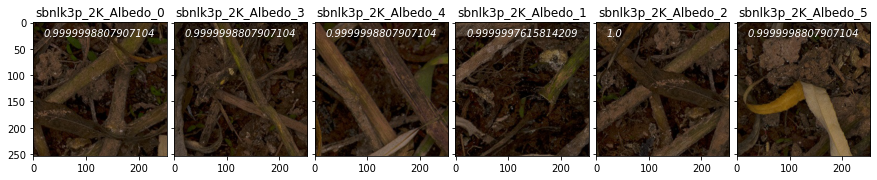

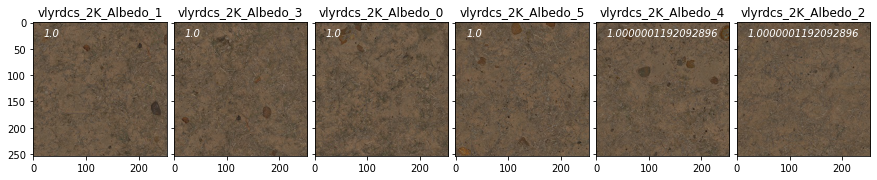

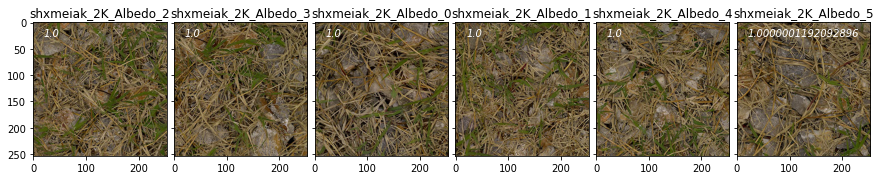

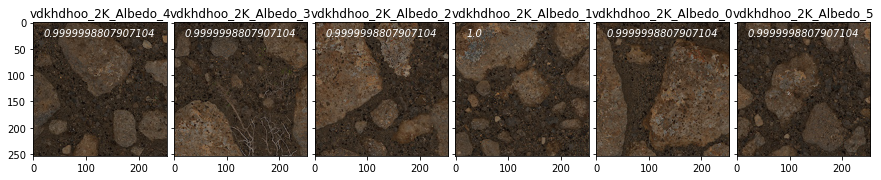

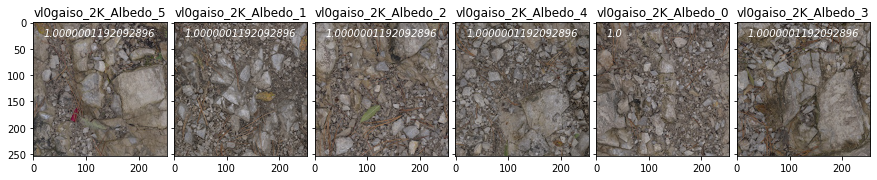

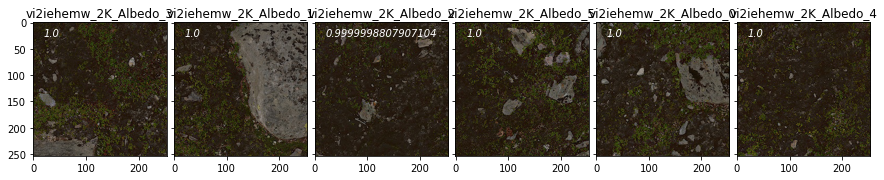

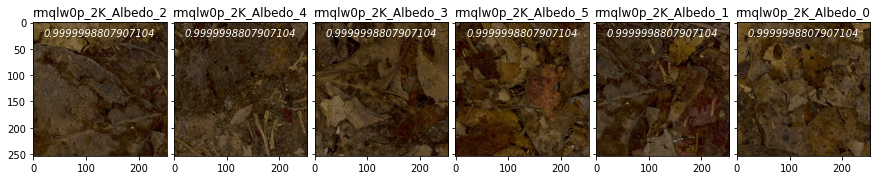

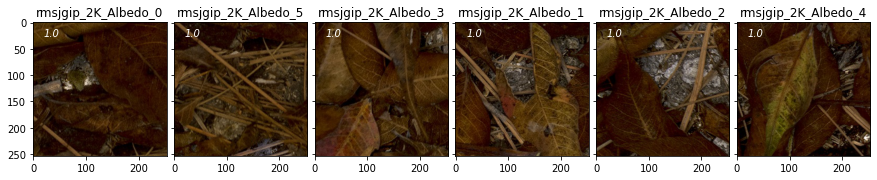

In [186]:
cosine_dictionary_same_image={}
for i in range(0,len(images_task21),6):
  z1=image_to_feature_numpy(images_task21[i])
  images=[]
  cousin_sim=[]
  img_name=[]
  for j in range(i,i+6):
    img=Image.open(images_task21[j])
    z2=image_to_feature_numpy(images_task21[j])
    cousin_sim.append(cosine_simalarity(z1,z2))
    images.append(img)
    img_name.append(os.path.basename(images_task21[j])[:-4])
  fig = plt.figure(figsize=(15, 20))
  grid = ImageGrid(fig, 111,  
                  nrows_ncols=(1, 6),  
                  axes_pad=0.1,  
                  )
  c=0
  for ax, im in zip(grid, images):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)
      ax.text(20, 25, '{}'.format(cousin_sim[c]) , style='italic',color='white')
      ax.set_title('{}'.format(img_name[c]))
      c+=1
  
  plt.show()
  fig.savefig(img_name[0][:-2]+'.png')

Cosine Similarity accross crops of different images selected Randomly. **1st image in each grid** have Cosine similarity with itself. 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


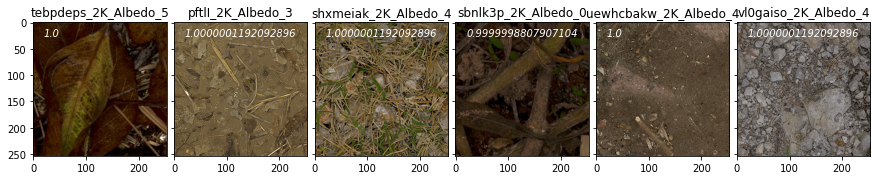

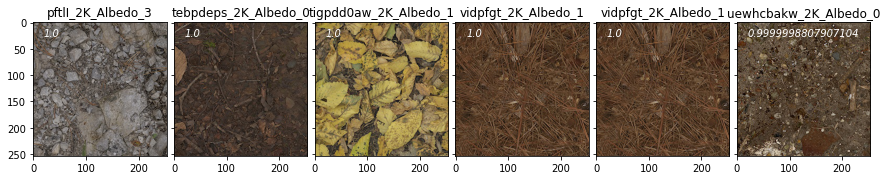

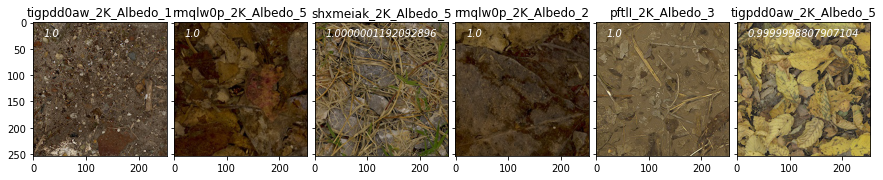

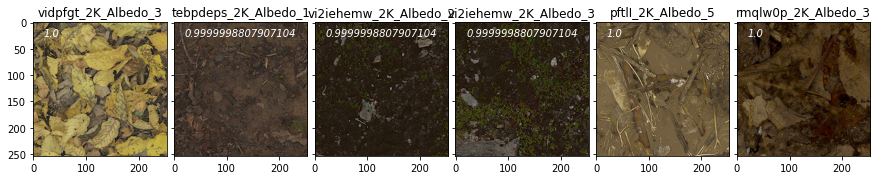

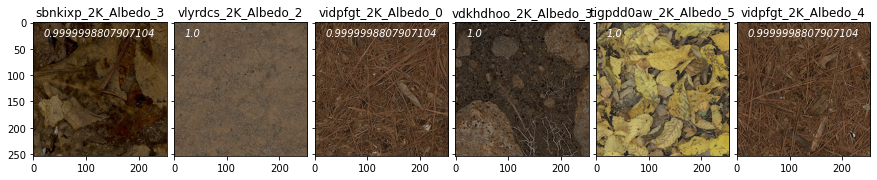

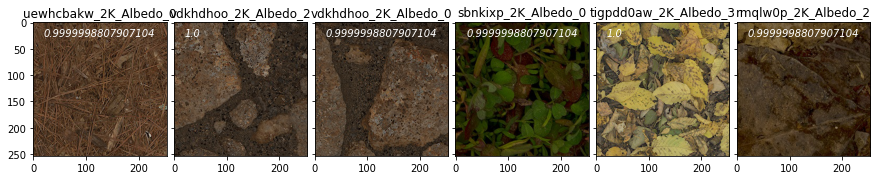

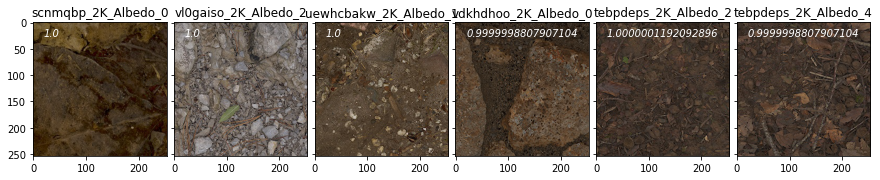

In [189]:
for i in range(0,40,6):
  z1=image_to_feature_numpy(images_task21[i])
  images=[]
  cousin_sim=[]
  img_name=[]
  img=Image.open(images_task21[j])
  images.append(img)
  z2=image_to_feature_numpy(images_task21[i])
  cousin_sim.append(cosine_simalarity(z1,z2))
  img_name.append(os.path.basename(images_task21[i])[:-4])
  random_image_crop_indexes=np.random.randint(len(images_task21), size=5)
  for j in random_image_crop_indexes:
    img=Image.open(images_task21[j])
    z2=image_to_feature_numpy(images_task21[j])
    cousin_sim.append(cosine_simalarity(z1,z2))
    images.append(img)
    img_name.append(os.path.basename(images_task21[j])[:-4])
  fig = plt.figure(figsize=(15, 20))
  grid = ImageGrid(fig, 111,  
                  nrows_ncols=(1, 6),  
                  axes_pad=0.1,  
                  )
  c=0
  for ax, im in zip(grid, images):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)
      ax.text(20, 25, '{}'.format(cousin_sim[c]) , style='italic',color='white')
      ax.set_title('{}'.format(img_name[c]))
      c+=1
  
  plt.show()
  fig.savefig(img_name[0][:-2]+'.png')

**Thanks for Reading. **